In [1]:
import pandas as pd
import numpy as np
import glob
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [2]:
def get_meta(path):
    """Returns (threads, num_jsons, repeats)"""

    props = os.path.splitext(os.path.basename(path))[0].split('_')
    values = [int(x[1:]) for x in props[1:]]

    return {'max_value':values[0],
            'max_num_values':values[1],
            'threads':values[2],
            'input_size_approx':values[3],
            'repeats':values[4]}

In [3]:
def load(file):
    """Load the experiment data from a CSV file with converter metrics."""
        
    schema = {
        'num_threads': np.int64(),
        'num_jsons_converted': np.int64(),
        'num_json_bytes_converted': np.int64(),
        'num_recordbatch_bytes': np.int64(),
        'num_ipc': np.int64(),
        'ipc_bytes': np.int64(),
        'num_buffers_converted': np.int64(),
        't_parse': np.float64(),
        't_resize': np.float64(),
        't_serialize': np.float64(),
        't_thread': np.float64(),
        't_enqueue': np.float64(),
        'status': np.int64()
    }
    
    df = pd.read_csv(file, dtype=schema)
    
    meta = get_meta(file)

    for key, value in meta.items():  
        df.insert(0, key, value)
        
    # Make sure there were no errors for converters.
    assert(df['status'].sum() == len(df.index))
        
    return df

In [4]:
def analyze(df):
    """Analyze the experiment data, deriving various metrics such as throughput."""
    # Calculate time spent within the thread as 'other'.
    df['t_other'] = df['t_thread'] - df[['t_parse', 't_resize', 't_serialize', 't_enqueue']].sum(axis=1)
    
    # Calculate the throughput per thread
    df['Parse throughput (in)'] = df['num_json_bytes_converted'] / df['t_parse']
    df['Parse throughput (out)'] = df['num_recordbatch_bytes'] / df['t_parse']
    
    return df

In [5]:
def aggr_counts(digit_counts):
    total = 0
    for n, d in digit_counts:
        total = total + n    
    return total
            
def avg_number_of_decimals(max_value):
    ''' Return avg number of decimals of uniform random numbers from 0 up to max_value. '''
    digits = 1
    digit_counts = []
    while (pow(10, digits) < max_value):
        nums = pow(10,digits) - aggr_counts(digit_counts)
        digit_counts.append((nums, digits))
        digits = digits + 1

    digit_counts.append((max_value - aggr_counts(digit_counts), digits))
    
    avg_num_digits = 0
    for n, d in digit_counts:
        avg_num_digits += n/max_value * d
        
    return avg_num_digits

In [6]:
def summarize(df):
    """Summarize the data from one run into one row with averages."""
    
    assert(len(pd.unique(df['max_value'])==1))
    assert(len(pd.unique(df['max_num_values'])==1))
    assert(len(pd.unique(df['threads'])==1))
    assert(len(pd.unique(df['input_size_approx'])==1))
    assert(df['num_threads'].sum()==pd.unique(df['threads'])[0])
    repeats = pd.unique(df['repeats'])[0]
    
    # Avg. value bytes per JSON is the average array size (which is half the max, it is uniform random)
    # times the average number of bytes for uniform random numbers between 0 and max value
    max_value = pd.unique(df['max_value'])[0]
    max_num_values = pd.unique(df['max_num_values'])[0]
    value_bytes = avg_number_of_decimals(max_value) * max_num_values / 2
    
    row = {'Max. value': max_value,
           'Max. number of values': max_num_values,
           'Value bytes': value_bytes,
           'Input size': pd.unique(df['input_size_approx'])[0],
           'Repeats': pd.unique(df['repeats'])[0],
           'Threads': df['num_threads'].sum(),
           'JSONs': df['num_jsons_converted'].sum() / repeats,
           'Bytes (in)': df['num_json_bytes_converted'].sum() / repeats,
           'RecordBatch bytes': df['num_recordbatch_bytes'].sum() / repeats,
           'IPC messages': df['num_ipc'].sum() / repeats,
           'IPC bytes': df['ipc_bytes'].sum() / repeats,
           'Buffers converted': df['num_buffers_converted'].sum() / repeats,
           # For time, we use the max time of all threads, 
           # since the throughput is determined by the slowest thread in the pool,
           # and they all start operating simultaneously
           'Parse time': df['t_parse'].max(),
           'Resize time': df['t_resize'].max(),
           'Serialize time': df['t_serialize'].max(),
           'Enqueue time': df['t_enqueue'].max(),
           'Other time': df['t_other'].max(),
           'Thread time': df['t_thread'].max(),
           'Parse throughput (in)': df['num_json_bytes_converted'].sum() / df['t_parse'].max(),
           'Parse throughput (out)': df['num_recordbatch_bytes'].sum() / df['t_parse'].max()}
              
    return row;

In [7]:
def get_all_data(data_path, schema, impl):
    path = '{}/{}/latency/threads/metrics/{}/'.format(data_path, schema, impl.lower())
    csv_files = []
    for file in glob.glob("{}*.csv".format(path)):
        csv_files.append(file)
    print("Found {} files in {}".format(len(csv_files), path))

    records = []
    for file in csv_files:
        records.append(summarize(analyze(load(file))))


    df = pd.DataFrame.from_records(records)
    df.sort_values(by=['Threads', 'JSONs'], inplace=True)
    df.insert(0,'Implementation', impl)
    
    # Use only max value
    df = df[df['Max. value'] == 18446744073709551615]
    display(pd.unique(df['Max. number of values']))
    
    # Print max throughput
    display('{} max: {}'.format(impl, df['Parse throughput (in)'].max() * 1e-9))
    # Print mean throughput of highest throughput per input size
    display('{} mean: {}'.format(impl, df.groupby(['Implementation', 'Input size']).agg({'Parse throughput (in)': 'max'})['Parse throughput (in)'].mean() * 1e-9))
    
    return df

In [8]:
def get_max_throughput_for_max_size(df):
    df = df[df.JSONs == df.JSONs.max()]
    #df.set_index('Threads', inplace=True)

    result = df[df['Parse throughput (in)'] == df['Parse throughput (in)'].max()]

    return result

In [9]:
import matplotlib.pyplot as plt
from utils import lighten_color

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

colors = ['#4878d0', '#6acc64', '#d65f5f', '#d5bb67', '#dc7ec0', '#8c613c']
markers = ['o', 's', 'd']

In [12]:
d_impls = []

d_impls.append(get_all_data('../experiments/data-p9', 'battery', 'Arrow'))
d_impls.append(get_all_data('../experiments/data-p9', 'battery', 'Custom'))
d_impls.append(get_all_data('../experiments/data-p9', 'battery', 'FPGA'))
#d_impls.append(get_all_data('../experiments/data-sigmax', 'battery', 'Arrow'))
#d_impls.append(get_all_data('../experiments/data-sigmax', 'battery', 'Custom'))
#d_impls.append(get_all_data('../experiments/data-sigmax', 'battery', 'FPGA'))

df = pd.concat(d_impls)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  

# Average the throughput of various number of max. array sizes
df = df.groupby(['Implementation', 'Threads', 'Input size']).agg({'Parse throughput (in)': 'mean'})
df = df.reset_index()
display(df)

max_tp = df['Parse throughput (in)'].max()

# Get all dimensions for plots
#max_values = pd.unique(df['Max. value'])
#max_num_values = pd.unique(df['Max. number of values'])
#value_bytes = np.sort(pd.unique(df['Value bytes']))
input_sizes = np.sort(pd.unique(df['Input size']))
threads = np.sort(pd.unique(df['Threads']))
impls = pd.unique(df['Implementation'])

#print("Value bytes    :", value_bytes)
print("Input sizes    :", input_sizes)
print("Threads        :", threads)
print("Impls          :", impls)

Found 272 files in ../experiments/data-p9/battery/latency/threads/metrics/arrow/


array([512,  64,   8,   1])

'Arrow max: 3.970858300924027'

'Arrow mean: 2.8238226874614907'

Found 272 files in ../experiments/data-p9/battery/latency/threads/metrics/custom/


array([512,  64,   8,   1])

'Custom max: 18.487980194674172'

'Custom mean: 11.815579487472064'

Found 16 files in ../experiments/data-p9/battery/latency/threads/metrics/fpga/


array([512,  64,   8,   1])

'FPGA max: 17.92687817481353'

'FPGA mean: 16.19216639760372'

,Implementation,Threads,Input size,Parse throughput (in)
0,Arrow,1,16777216,6.388852e+07
1,Arrow,1,134217728,6.412158e+07
2,Arrow,1,1073741824,6.360778e+07
3,Arrow,1,8589934592,6.400122e+07
4,Arrow,11,16777216,4.243717e+08
...,...,...,...,...
135,Custom,176,8589934592,1.719200e+10
136,FPGA,20,16777216,1.187991e+10
137,FPGA,20,134217728,1.557784e+10
138,FPGA,20,1073741824,1.749980e+10


Input sizes    : [  16777216  134217728 1073741824 8589934592]
Threads        : [  1  11  20  22  33  44  55  66  77  88  99 110 121 132 143 154 165 176]
Impls          : ['Arrow' 'Custom' 'FPGA']


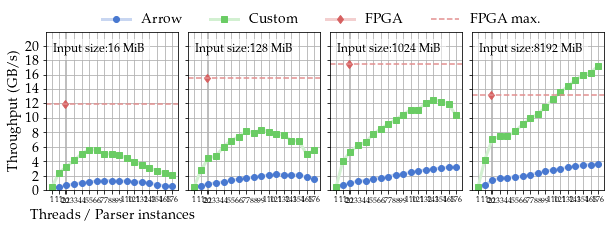

In [13]:
fig, axs = plt.subplots(ncols=len(input_sizes), figsize=[10, 3], sharey=True, sharex=True)

handles = {}

for xa, inps in enumerate(input_sizes):
    ax = axs[xa]

    for i, impl in enumerate(impls):
        # Prepare plotting data
        dl = df[(df['Input size'] == inps) & (df['Implementation'] == impl)]
        y = dl['Parse throughput (in)'] * 1e-9
        x = dl['Threads']

        # Plot FPGA data
        handles[impl], = ax.plot(x, y, c=lighten_color(colors[i],0.3), marker=markers[i], mfc=colors[i], mec=colors[i], linewidth=3)

        if impl == 'FPGA':
            handles['FPGA max.'] = ax.axhline(y=max(y.to_numpy()), color=lighten_color(colors[i],0.7), ls='--')



    # Set inline 
    ax.annotate("Input size:{:.0f} MiB".format(inps / (1<<20)), 
                xycoords='axes fraction', 
                xy=(0.05, 0.875), 
                fontsize=12,
                backgroundcolor='#FFFFFF80')

    ax.set_xticks(threads)
    ax.set_xticklabels(threads, rotation=0, fontsize=8)

    ax.set_yticks(range(0, 25,2))
    ax.set_ylim(0, 1.25*max_tp * 1e-9)

    ax.grid(which='both')

    if xa == 0:
        ax.set_xlabel('Threads / Parser instances')
        ax.set_ylabel('Throughput (GB/s)')
                        
leg_handles = [v for k,v in handles.items()]
leg_labels = [k for k,v in handles.items()]
fig.legend(leg_handles, leg_labels, ncol=4, bbox_to_anchor=(-0.17, 0.93, 1.0, 0.1), frameon=False)
plt.subplots_adjust(hspace = .1, wspace = .075, bottom=0.15)

fig.savefig("throughput-battery-p9.pdf")